<a href="https://colab.research.google.com/github/brunelliMichele/py.tatine/blob/main/Image_similarity_%5BResNet%2BCosSim%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tentativo usando codice preimpostato di https://www.kaggle.com/code/armanzhalgasbayev/image-search-engine-demo-resnet-cossim.

Modello:ResNet50


distance function: Cosine Similarity

In [10]:
dataset_path = "/content/drive/MyDrive/competition_ML/training"


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset


Dataset ImageFolder
    Number of datapoints: 36
    Root location: /content/drive/MyDrive/competition_ML/training
    StandardTransform
Transform: ToTensor()

# Image Search Engine Demo based on ResNet50 feature extraction and CosineSimilarity Search

🎯 **Goal:** demonstrating the logic of an image search engine using ResNet50 for feature extraction and cosine similarity for searching similar images.

## Import necessary libraries

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import random

%matplotlib inline

tqdm.pandas()


## Load Images

In [14]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

In [15]:

import os

image_files = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))


In [16]:
image_files

['/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_11139.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_10431.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_17809.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_2370.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_13234.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_21745.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_10699.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_14702.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_7441.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_10338.jpg',
 '/content/drive/MyDrive/competition_ML/training/American_chameleon/n01682714_17622.jpg',
 '/content/d

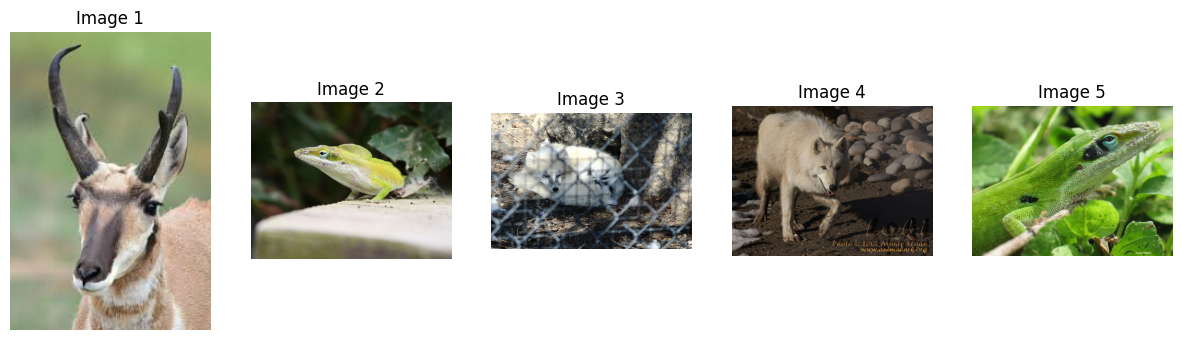

In [17]:
def display_random_images(image_files, num_images=5):
    random_images = random.sample(image_files, num_images)
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(random_images):
        img = image.load_img(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.show()

display_random_images(image_files, 5)

## Extract Features from Images Using ResNet50

~ We are using ResNet50 pre-trained on ImageNet to extract features from images

~ ResNet50’s combination of `residual learning, effective depth, pre-training on a large-scale dataset, computational efficiency, and versatility` make it an excellent choice for feature extraction in a wide range of computer vision tasks.

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(model, img_path):
    img_data = load_and_preprocess_image(img_path)
    features = model.predict(img_data, verbose=0)
    return features.flatten()

# ~ extract features for all images
image_features = []

for img_path in tqdm(image_files, desc="Extracting features"):
    features = extract_features(base_model, img_path)
    image_features.append(features)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Extracting features: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it]


In [19]:
image_features = np.array(image_features) # convert to numpy array for faster manipulation

## Set Up the Image Search Engine Based on Cosine Similarity

~ The idea behind of this Image Search Algorithm is to calculate similarities between a given image and all other images from the main dataset for returning the indices of the top k candidates.

In [20]:
def search_similar_images(query_image_index, image_features, image_files, k=5):
    query_feature = image_features[query_image_index].reshape(1, -1)
    similarities = cosine_similarity(query_feature, image_features).flatten()
    top_k_indices = similarities.argsort()[-k-1:-1][::-1]  # ~ exclude the query image itself
    return top_k_indices

## Show / Display Final Results

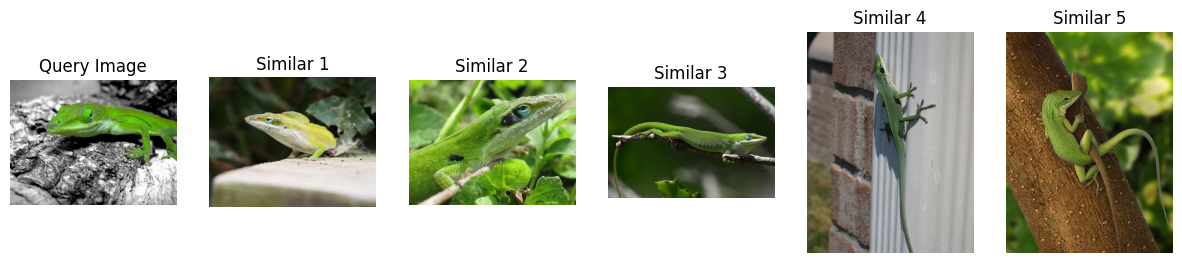

In [21]:
# EXAMPLE:
query_image_index = random.randint(0, len(image_files) - 1) # ~ get random image from

# ~ get top 5 similar images
top_k_indices = search_similar_images(query_image_index, image_features, image_files, k=5)

def display_images(query_image_path, similar_image_paths):
    plt.figure(figsize=(15, 5))

    # ~ show query image
    plt.subplot(1, len(similar_image_paths) + 1, 1)
    plt.imshow(image.load_img(query_image_path))
    plt.title("Query Image")
    plt.axis('off')

    # ~ show similar images
    for i, img_path in enumerate(similar_image_paths):
        plt.subplot(1, len(similar_image_paths) + 1, i + 2)
        plt.imshow(image.load_img(img_path))
        plt.title(f"Similar {i+1}")
        plt.axis('off')

    plt.show()

# ~ display results
query_image_path = image_files[query_image_index]
similar_image_paths = [image_files[idx] for idx in top_k_indices]
display_images(query_image_path, similar_image_paths)

Extracting gallery features: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Query Image: /content/drive/MyDrive/competition_ML/test/query/4597118805213184.jpg
Top 5 Similar Images:
1. /content/drive/MyDrive/competition_ML/test/gallery/painting_085_000045.jpg
2. /content/drive/MyDrive/competition_ML/test/gallery/painting_085_000118.jpg
3. /content/drive/MyDrive/competition_ML/test/gallery/painting_085_000084.jpg
4. /content/drive/MyDrive/competition_ML/test/gallery/n01855672_4197.jpg
5. /content/drive/MyDrive/competition_ML/test/gallery/n01855672_1037.jpg


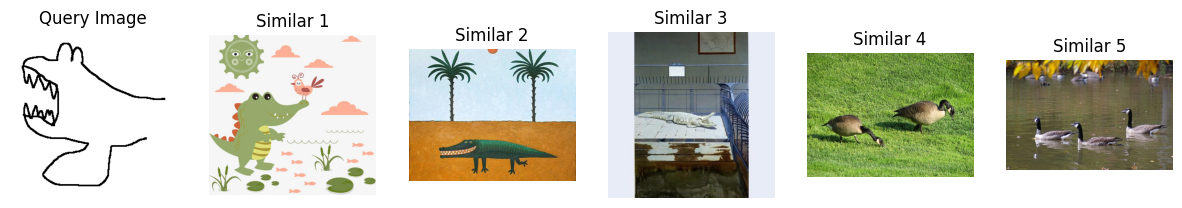

In [22]:
# prompt: ora voglio testare il modello su testing set. il test set, in drive, è diviso in query e galley

import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Paths to query and gallery datasets
query_dataset_path = "/content/drive/MyDrive/competition_ML/test/query"
gallery_dataset_path = "/content/drive/MyDrive/competition_ML/test/gallery"

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

# Load image files
query_image_files = [os.path.join(query_dataset_path, f) for f in os.listdir(query_dataset_path) if f.endswith('.jpg') or f.endswith('.png')]
gallery_image_files = [os.path.join(gallery_dataset_path, f) for f in os.listdir(gallery_dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

# Initialize ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features
def extract_features(model, img_path):
    img_data = load_and_preprocess_image(img_path)
    features = model.predict(img_data, verbose=0)
    return features.flatten()

# Extract features from gallery images
gallery_image_features = []
for img_path in tqdm(gallery_image_files, desc="Extracting gallery features"):
    features = extract_features(base_model, img_path)
    gallery_image_features.append(features)
gallery_image_features = np.array(gallery_image_features)

# Search similar images
def search_similar_images(query_image_path, gallery_image_features, gallery_image_files, k=5):
    query_feature = extract_features(base_model, query_image_path).reshape(1, -1)
    similarities = cosine_similarity(query_feature, gallery_image_features).flatten()
    top_k_indices = similarities.argsort()[-k:][::-1]
    return top_k_indices


# Example usage for the first query image
query_image_path = query_image_files[0]
top_k_indices = search_similar_images(query_image_path, gallery_image_features, gallery_image_files, k=5)

# Display results (you can adapt this to your needs)
print("Query Image:", query_image_path)
print("Top 5 Similar Images:")
for i, index in enumerate(top_k_indices):
    print(f"{i+1}. {gallery_image_files[index]}")

# Display query and similar images
plt.figure(figsize=(15, 5))

plt.subplot(1, 6, 1)
plt.imshow(image.load_img(query_image_path))
plt.title("Query Image")
plt.axis('off')

for i, index in enumerate(top_k_indices):
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.load_img(gallery_image_files[index]))
    plt.title(f"Similar {i+1}")
    plt.axis('off')

plt.show()
